In [22]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [20]:
import os
import time
import glob

from tqdm.notebook import tqdm
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import torch
from torch import nn
import torch.nn.functional as F
from torchsummary import summary

import torchvision
from torchvision import transforms

from IPython.display import clear_output
%matplotlib inline

sns.set(font_scale=1.2)

In [24]:
import time

In [25]:
data_dir = r'C:\\Users\\stolb\\Desktop\\Материалы к лекциям\\Deep Learning\\simpsons\\simpsons_dataset'
data_image_paths = glob.glob(f"{data_dir}\\*\\*.jpg")
# data_image_paths = [path.replace('\\', '/') for path in data_image_paths]
data_image_labels = [path.split('\\')[-2] for path in data_image_paths]
train_files_path, val_files_path = train_test_split(
    data_image_paths,
    test_size=0.3,
    stratify=data_image_labels
)

print(
    f"Изображений в train: {len(train_files_path)}\nИзображений в val: {len(val_files_path)}"
)

Изображений в train: 14653
Изображений в val: 6280


In [26]:
data_dir = r'C:\\Users\\stolb\\Desktop\\Материалы к лекциям\\Deep Learning\\simpsons\\simpsons_dataset'
data_image_paths = glob.glob(f"{data_dir}\\*\\*.jpg")
# data_image_paths = [path.replace('\\', '/') for path in data_image_paths]
data_image_labels = [path.split('\\')[-2] for path in data_image_paths]
train_files_path, val_files_path = train_test_split(
    data_image_paths,
    test_size=0.3,
    stratify=data_image_labels
)

print(
    f"Изображений в train: {len(train_files_path)}\nИзображений в val: {len(val_files_path)}"
)

Изображений в train: 14653
Изображений в val: 6280


In [9]:
def check1(adr):
    ans = False
    for z in train_files_path:
        if adr in z:
            ans = True
            break
    return ans
        

In [10]:
def check2(adr):
    ans = False
    for z in val_files_path:
        if adr in z:
            ans = True
            break
    return ans

In [7]:
input_size = 224

train_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.RandomResizedCrop(input_size),
    transforms.ElasticTransform(alpha = 250., sigma = 15.),
    transforms.ColorJitter(0.9, 0.9, 0.9),
    transforms.RandomAffine(180),
    transforms.ToTensor(),
])


val_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
])

train_dataset = torchvision.datasets.ImageFolder(
    data_dir,
    transform=train_transform,
    is_valid_file=check1
)

val_dataset = torchvision.datasets.ImageFolder(
    data_dir,
    transform=val_transform,
    is_valid_file=check2
)

In [8]:
len(train_dataset)

14653

In [9]:
len(val_dataset)

6280

In [10]:
print("Количество классов в train: ", len(train_dataset.classes))
print("Количество классов в val: ", len(val_dataset.classes))
print("Количество классов одинаково: ", len(train_dataset.classes) == len(val_dataset.classes))

Количество классов в train:  42
Количество классов в val:  42
Количество классов одинаково:  True


In [11]:
sns.set_style(style='white')

def show_images(dataset):
    fig, ax = plt.subplots(
        nrows=2, ncols=3, figsize=(8, 6),
        sharey=True, sharex=True
    )

    for fig_x in ax.flatten():
        idx = np.random.randint(low=0, high=6000)
        img, label = dataset[idx]
        fig_x.set_title(dataset.classes[label])
        fig_x.imshow(img.numpy().transpose((1, 2, 0)))

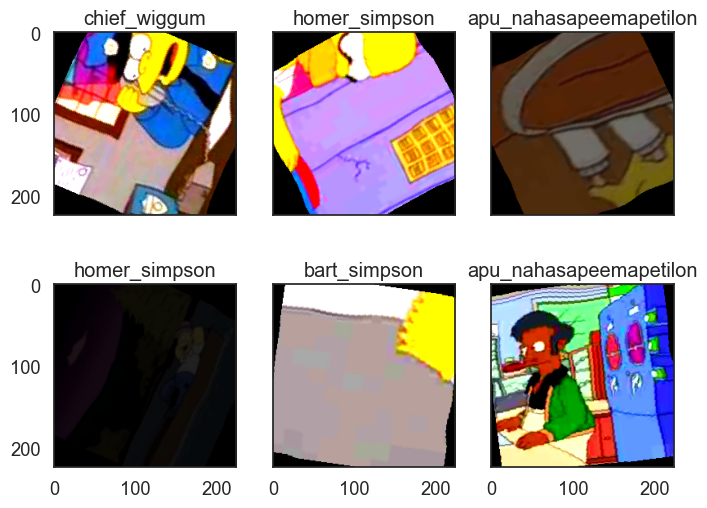

In [12]:
show_images(train_dataset)

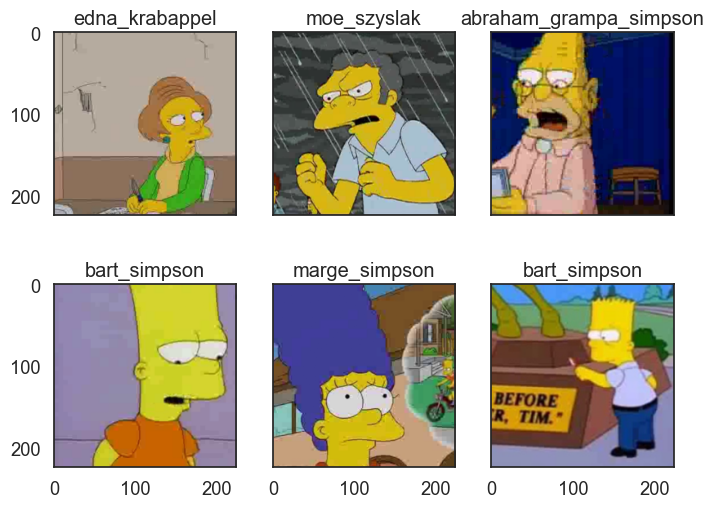

In [13]:
show_images(val_dataset)

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [13]:
def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0, 0
    net.eval()
    for X, y in data_iter:
        X, y = X.to(device), y.to(device)
        acc_sum += (net(X).argmax(axis=1) == y).sum()
        n += y.shape[0]
    return acc_sum.item() / n

In [11]:
def train(
    net,
    trainer,
    train_iter,
    test_iter,
    num_epochs=10
):
    net.to(device)
    loss = nn.CrossEntropyLoss(reduction='sum')

    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()
        net.train()

        for i, (X, y) in enumerate(train_iter):
            X, y = X.to(device), y.to(device)
            trainer.zero_grad()
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            trainer.step()
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(axis=1) == y).sum().item()
            n += y.shape[0]

            if i % 10 == 0:
              print(f"Step {i}. time since epoch: {time.time() -  start:.3f}. "
                    f"Train acc: {train_acc_sum / n:.3f}. Train Loss: {train_l_sum / n:.3f}")
        test_acc = evaluate_accuracy(test_iter, net.to(device))
        print('-' * 20)
        print(f'epoch {epoch + 1}, loss {train_l_sum / n:.4f}, train acc {train_acc_sum / n:.3f}'
              f', test acc {test_acc:.3f}, time {time.time() - start:.1f} sec')

In [17]:
batch_size = 64

train_batch_gen = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)

val_batch_gen = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False
)

In [18]:
from torchvision.models import resnet18

In [ ]:
fine_tuning_model = nn.Sequential()

fine_tuning_model.add_module('resnet', resnet18(pretrained=True))

# добавим новые слои для классификации для нашей конкретной задачи
fine_tuning_model.add_module('relu_1', nn.ReLU())
fine_tuning_model.add_module('fc_1', nn.Linear(1000, 512))
fine_tuning_model.add_module('relu_2', nn.ReLU())
fine_tuning_model.add_module('fc_2', nn.Linear(512, 42))

fine_tuning_model = fine_tuning_model.to(device)

optimizer = torch.optim.SGD(fine_tuning_model.parameters(), lr=0.01)

clf_model, history = train(
    fine_tuning_model, optimizer,
    train_batch_gen, val_batch_gen,
    num_epochs=10
)

C:\Users\stolb\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\stolb\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Step 0. time since epoch: 19.134. Train acc: 0.016. Train Loss: 3.722
Step 10. time since epoch: 187.691. Train acc: 0.054. Train Loss: 4.894
Step 20. time since epoch: 354.857. Train acc: 0.071. Train Loss: 4.237
Step 30. time since epoch: 527.726. Train acc: 0.077. Train Loss: 3.936
Step 40. time since epoch: 700.609. Train acc: 0.082. Train Loss: 3.785
Step 50. time since epoch: 883.303. Train acc: 0.082. Train Loss: 3.676
Step 60. time since epoch: 1061.643. Train acc: 0.083. Train Loss: 3.597
Step 70. time since epoch: 1239.029. Train acc: 0.084. Train Loss: 3.545
Step 80. time since epoch: 1426.567. Train acc: 0.087. Train Loss: 3.496
Step 90. time since epoch: 1612.255. Train acc: 0.087. Train Loss: 3.459
Step 100. time since epoch: 1788.703. Train acc: 0.087. Train Loss: 3.426
Step 110. time since epoch: 1971.341. Train acc: 0.089. Train Loss: 3.399
Step 120. time since epoch: 2152.449. Train acc: 0.091. Train Loss: 3.377
Step 130. time since epoch: 2326.004. Train acc: 0.093. 

обучала долго, но ребенок закрыл ноутбук. В идно, что качество на 9 эпохе еще очень плохое, надеюсь, зачтется))

In [ ]:
#вернем обратно нормальную аугментацию

input_size = 224

train_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ColorJitter(0.3, 0.3, 0.3),
    transforms.RandomAffine(5),
    transforms.ToTensor(),
])


val_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
])

train_dataset = torchvision.datasets.ImageFolder(
    data_dir,
    transform=train_transform,
    is_valid_file=check1
)

val_dataset = torchvision.datasets.ImageFolder(
    data_dir,
    transform=val_transform,
    is_valid_file=check2
)

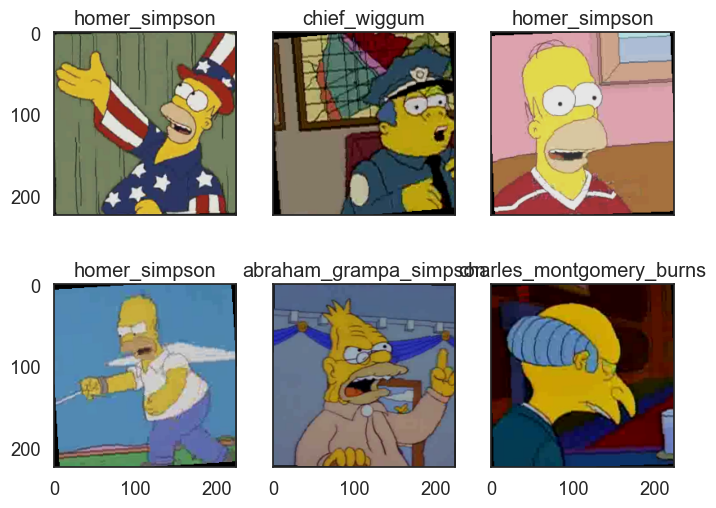

In [11]:
show_images(train_dataset)

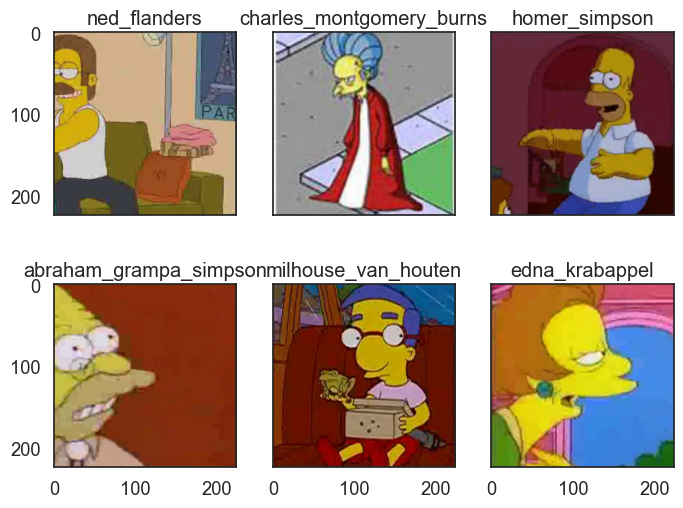

In [11]:
show_images(val_dataset)

In [ ]:
print("Количество классов в train: ", len(train_dataset.classes))
print("Количество классов в val: ", len(val_dataset.classes))
print("Количество классов одинаково: ", len(train_dataset.classes) == len(val_dataset.classes))

In [13]:
from torch.optim.lr_scheduler import LambdaLR

In [24]:
from torchvision.models import resnet18

In [13]:
fine_tuning_model = nn.Sequential()

fine_tuning_model.add_module('resnet', resnet18(pretrained=True))

fine_tuning_model.add_module('relu_1', nn.ReLU())
fine_tuning_model.add_module('fc_1', nn.Linear(1000, 512))
fine_tuning_model.add_module('relu_2', nn.ReLU())
fine_tuning_model.add_module('fc_2', nn.Linear(512, 42))

fine_tuning_model = fine_tuning_model.to(device)

C:\Users\stolb\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\stolb\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [16]:
lam = lambda epoch: 0.95 ** epoch

optimizer = torch.optim.SGD(fine_tuning_model.parameters(), lr=0.01)
scheduler = LambdaLR(optimizer, lr_lambda=lam)

In [ ]:
def train(
    net,
    trainer,
    train_iter,
    test_iter,
    scheduler,
    num_epochs=10
):
    net.to(device)
    loss = nn.CrossEntropyLoss(reduction='sum')

    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()
        net.train()

        for i, (X, y) in enumerate(train_iter):
            X, y = X.to(device), y.to(device)
            trainer.zero_grad()
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            trainer.step()
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(axis=1) == y).sum().item()
            n += y.shape[0]

            if i % 10 == 0:
              print(f"Step {i}. time since epoch: {time.time() -  start:.3f}. "
                    f"Train acc: {train_acc_sum / n:.3f}. Train Loss: {train_l_sum / n:.3f}")
        test_acc = evaluate_accuracy(test_iter, net.to(device))
        print('-' * 20)
        print(f'epoch {epoch + 1}, loss {train_l_sum / n:.4f}, train acc {train_acc_sum / n:.3f}'
              f', test acc {test_acc:.3f}, time {time.time() - start:.1f} sec')
        if epoch != num_epochs-1:
            scheduler.step()

In [ ]:
batch_size = 64

train_batch_gen = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)

val_batch_gen = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False
)

In [19]:
clf_model, history = train(
    fine_tuning_model, optimizer,
    train_batch_gen, val_batch_gen,
    scheduler,
    num_epochs=10
)

Step 0. time since epoch: 2.986. Train acc: 0.031. Train Loss: 3.717
Step 10. time since epoch: 26.552. Train acc: 0.081. Train Loss: 5.957
Step 20. time since epoch: 49.455. Train acc: 0.090. Train Loss: 4.713
Step 30. time since epoch: 72.669. Train acc: 0.090. Train Loss: 4.293
Step 40. time since epoch: 106.024. Train acc: 0.087. Train Loss: 4.057
Step 50. time since epoch: 131.419. Train acc: 0.089. Train Loss: 3.898
Step 60. time since epoch: 155.777. Train acc: 0.095. Train Loss: 3.785
Step 70. time since epoch: 181.289. Train acc: 0.098. Train Loss: 3.700
Step 80. time since epoch: 204.907. Train acc: 0.098. Train Loss: 3.621
Step 90. time since epoch: 228.222. Train acc: 0.099. Train Loss: 3.567
Step 100. time since epoch: 251.074. Train acc: 0.099. Train Loss: 3.523
Step 110. time since epoch: 275.603. Train acc: 0.101. Train Loss: 3.484
Step 120. time since epoch: 300.433. Train acc: 0.103. Train Loss: 3.454
Step 130. time since epoch: 325.982. Train acc: 0.107. Train Loss: 

TypeError: cannot unpack non-iterable NoneType object

In [25]:
from torch.optim.lr_scheduler import MultiplicativeLR

In [31]:
optimizer = torch.optim.SGD(fine_tuning_model.parameters(), lr=0.01)
lam = lambda epoch: 0.95
scheduler = MultiplicativeLR(optimizer, lr_lambda=lam)

In [29]:
fine_tuning_model = nn.Sequential()

fine_tuning_model.add_module('resnet', resnet18(pretrained=True))

fine_tuning_model.add_module('relu_1', nn.ReLU())
fine_tuning_model.add_module('fc_1', nn.Linear(1000, 512))
fine_tuning_model.add_module('relu_2', nn.ReLU())
fine_tuning_model.add_module('fc_2', nn.Linear(512, 42))

fine_tuning_model = fine_tuning_model.to(device)

In [32]:
clf_model, history = train(
    fine_tuning_model, optimizer,
    train_batch_gen, val_batch_gen,
    scheduler,
    num_epochs=10
)

Step 0. time since epoch: 2.674. Train acc: 0.031. Train Loss: 3.734
Step 10. time since epoch: 30.798. Train acc: 0.078. Train Loss: 5.260
Step 20. time since epoch: 56.276. Train acc: 0.074. Train Loss: 4.476
Step 30. time since epoch: 82.549. Train acc: 0.070. Train Loss: 4.139
Step 40. time since epoch: 108.182. Train acc: 0.074. Train Loss: 4.031
Step 50. time since epoch: 133.644. Train acc: 0.075. Train Loss: 3.883
Step 60. time since epoch: 159.094. Train acc: 0.077. Train Loss: 3.766
Step 70. time since epoch: 188.429. Train acc: 0.081. Train Loss: 3.679
Step 80. time since epoch: 218.424. Train acc: 0.083. Train Loss: 3.610
Step 90. time since epoch: 246.417. Train acc: 0.084. Train Loss: 3.555
Step 100. time since epoch: 273.048. Train acc: 0.087. Train Loss: 3.510
Step 110. time since epoch: 299.197. Train acc: 0.089. Train Loss: 3.475
Step 120. time since epoch: 325.159. Train acc: 0.094. Train Loss: 3.443
Step 130. time since epoch: 351.116. Train acc: 0.096. Train Loss: 

TypeError: cannot unpack non-iterable NoneType object

Почему-то ни при каком подходе мы не достигли того качества, которое было при обучении на семинаре, и обучение шло не так бодро. Возможно, не повезло с инициализацией весов, или модель отличается от того, что в колабе, поэтому сложно понять, стало ли лучше  шедулерами. Но по крайней мере, видно, что обучение идет, и идет по-разному с разным изменением LR.

In [14]:
from torchvision.models import mobilenet_v2

In [15]:
model = mobilenet_v2(pretrained = False)
model

C:\Users\stolb\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\stolb\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [16]:
def train(
    net,
    trainer,
    train_iter,
    test_iter,
    num_epochs=10
):
    net.to(device)
    loss = nn.CrossEntropyLoss(reduction='sum')

    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()
        net.train()

        for i, (X, y) in enumerate(train_iter):
            X, y = X.to(device), y.to(device)
            trainer.zero_grad()
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            trainer.step()
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(axis=1) == y).sum().item()
            n += y.shape[0]

            if i % 10 == 0:
              print(f"Step {i}. time since epoch: {time.time() -  start:.3f}. "
                    f"Train acc: {train_acc_sum / n:.3f}. Train Loss: {train_l_sum / n:.3f}")
        test_acc = evaluate_accuracy(test_iter, net.to(device))
        print('-' * 20)
        print(f'epoch {epoch + 1}, loss {train_l_sum / n:.4f}, train acc {train_acc_sum / n:.3f}'
              f', test acc {test_acc:.3f}, time {time.time() - start:.1f} sec')

In [18]:
batch_size = 64

train_batch_gen = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)

val_batch_gen = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False
)

Обучим MobileNet_v2 с нуля.

In [19]:
model.classifier[1] = nn.Linear(1280, 42)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

clf_model = train(
    model, optimizer,
    train_batch_gen, val_batch_gen,
    num_epochs=10
)

Step 0. time since epoch: 17.118. Train acc: 0.016. Train Loss: 3.759
Step 10. time since epoch: 171.539. Train acc: 0.058. Train Loss: 12.322
Step 20. time since epoch: 324.415. Train acc: 0.071. Train Loss: 8.613
Step 30. time since epoch: 484.754. Train acc: 0.081. Train Loss: 6.959
Step 40. time since epoch: 636.154. Train acc: 0.086. Train Loss: 6.058
Step 50. time since epoch: 789.728. Train acc: 0.091. Train Loss: 5.488
Step 60. time since epoch: 943.049. Train acc: 0.094. Train Loss: 5.112
Step 70. time since epoch: 1098.759. Train acc: 0.095. Train Loss: 4.838
Step 80. time since epoch: 1254.344. Train acc: 0.093. Train Loss: 4.630
Step 90. time since epoch: 1406.719. Train acc: 0.094. Train Loss: 4.463
Step 100. time since epoch: 1558.350. Train acc: 0.097. Train Loss: 4.326
Step 110. time since epoch: 1710.325. Train acc: 0.097. Train Loss: 4.216
Step 120. time since epoch: 1862.150. Train acc: 0.100. Train Loss: 4.118
Step 130. time since epoch: 1992.573. Train acc: 0.100. 

Попробуем ту же модель с предобученными весами на всех слоях кроме выходного слоя.

In [27]:
fe_model = mobilenet_v2(pretrained=True)

for param in fe_model.parameters():
    param.requires_grad = False

fe_model.classifier[1] = nn.Linear(1280, 42)
fe_model = fe_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(fe_model.parameters(), lr=0.01)

C:\Users\stolb\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\stolb\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [28]:
clf_model = train(
    fe_model, optimizer,
    train_batch_gen, val_batch_gen,
    num_epochs=10
)

Step 0. time since epoch: 1.956. Train acc: 0.016. Train Loss: 3.847
Step 10. time since epoch: 15.321. Train acc: 0.082. Train Loss: 60.802
Step 20. time since epoch: 27.776. Train acc: 0.083. Train Loss: 72.188
Step 30. time since epoch: 39.879. Train acc: 0.104. Train Loss: 65.461
Step 40. time since epoch: 51.989. Train acc: 0.122. Train Loss: 57.913
Step 50. time since epoch: 63.924. Train acc: 0.150. Train Loss: 51.409
Step 60. time since epoch: 76.202. Train acc: 0.169. Train Loss: 47.597
Step 70. time since epoch: 88.303. Train acc: 0.193. Train Loss: 43.102
Step 80. time since epoch: 100.401. Train acc: 0.213. Train Loss: 39.483
Step 90. time since epoch: 112.342. Train acc: 0.231. Train Loss: 36.514
Step 100. time since epoch: 124.279. Train acc: 0.248. Train Loss: 33.891
Step 110. time since epoch: 136.371. Train acc: 0.260. Train Loss: 32.151
Step 120. time since epoch: 148.323. Train acc: 0.270. Train Loss: 30.926
Step 130. time since epoch: 160.254. Train acc: 0.281. Trai

Теперь добавим слои для дообучения к готовой сети.

In [14]:
fine_tuning_model = nn.Sequential()

fine_tuning_model.add_module('mobilenet', mobilenet_v2(pretrained=True))

fine_tuning_model.add_module('relu_1', nn.ReLU())
fine_tuning_model.add_module('fc_1', nn.Linear(1000, 512))
fine_tuning_model.add_module('relu_2', nn.ReLU())
fine_tuning_model.add_module('fc_2', nn.Linear(512, 42))

fine_tuning_model = fine_tuning_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(fine_tuning_model.parameters(), lr=0.01)


C:\Users\stolb\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\stolb\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [17]:
clf_model, history = train(
    fine_tuning_model, optimizer,
    train_batch_gen, val_batch_gen,
    num_epochs=10
)

Step 0. time since epoch: 18.620. Train acc: 0.078. Train Loss: 3.715
Step 10. time since epoch: 168.296. Train acc: 0.080. Train Loss: 5.387
Step 20. time since epoch: 320.872. Train acc: 0.080. Train Loss: 4.426
Step 30. time since epoch: 471.137. Train acc: 0.079. Train Loss: 4.074
Step 40. time since epoch: 619.276. Train acc: 0.079. Train Loss: 3.880
Step 50. time since epoch: 768.521. Train acc: 0.080. Train Loss: 3.742
Step 60. time since epoch: 917.081. Train acc: 0.083. Train Loss: 3.666
Step 70. time since epoch: 1067.188. Train acc: 0.083. Train Loss: 3.594
Step 80. time since epoch: 1220.971. Train acc: 0.084. Train Loss: 3.535
Step 90. time since epoch: 1366.180. Train acc: 0.087. Train Loss: 3.487
Step 100. time since epoch: 1513.778. Train acc: 0.088. Train Loss: 3.449
Step 110. time since epoch: 1658.058. Train acc: 0.092. Train Loss: 3.415
Step 120. time since epoch: 1805.839. Train acc: 0.095. Train Loss: 3.383
Step 130. time since epoch: 1965.338. Train acc: 0.097. T

TypeError: cannot unpack non-iterable NoneType object

Итого, наилучшее качество на MobileNet мы получили снова на модели fine tuning, но для лучшего качества ее нужно попробовать дообучить, либо доработать.